In [1]:
import os
import glob
import pandas as pd
import numpy as np
import librosa
import random
import time 
import pickle
import queue
import threading

import scipy.io.wavfile as wav
from scipy.fftpack import fft
from scipy import signal
from scipy.spatial.distance import squareform

from librosa.display import specshow, waveplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import IPython.display as ipd

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

%matplotlib inline

In [13]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Input, BatchNormalization, CuDNNLSTM
from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Introduction

As we did in the previous Notebook regarding Speech Claissification with an Audio MNIST Dataset, ze zill now try to classify audio file from FMA dataset. The downloaded dataset contains 8000 audio samples of 30s (this is the small one, there is a medium of 25gb with 25k audio and a large one close to 1Tb with a lot more audio clip). As this is a trial, the small dataset will be enought and the advantage is to have a balanced dataset of 8 classes. Let's start by cleaning up datas we have from attached dataset

# Cleanup Datasets

To start we will check the content of all files but our current objective is <b>only</b> to extract classes we have for our audio files. We will use other metadata in a futur notebook.

### genres

In [2]:
genres = pd.read_csv("fma_metadata/genres.csv", index_col=0)
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


So for nearly every genres, we have a parent class. This is because we can decompose a music genre into multiple sub-genres. For our dataset, we will focus only on top-level genres to have a balanced dataset

### artist

In [3]:
artists = pd.read_csv("fma_metadata/raw_artists.csv", index_col=0)
artists.head()

,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_contact,artist_date_created,artist_donation_url,artist_favorites,artist_flattr_name,...,artist_location,artist_longitude,artist_members,artist_name,artist_paypal_name,artist_related_projects,artist_url,artist_website,artist_wikipedia_page,tags
artist_id,,,,,,,,,,,,,,,,,,,,,
1,2006.0,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,Brown Bum aka Choke,11/26/2008 01:42:32 AM,NaN,9,NaN,...,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,NaN,The list of past projects is 2 long but every1...,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,NaN,['awol']
10,NaN,NaN,"Mistletone, Marriage Records","<p>""Lucky Dragons"" means any recorded or perfo...",3,Lukey Dargons,11/26/2008 01:43:35 AM,http://glaciersofnice.com/shop/,111,NaN,...,"Los Angeles, CA",-118.243685,Luke Fischbeck\nSarah Rara,Lucky Dragons,NaN,NaN,http://freemusicarchive.org/music/Lucky_Dragons/,http://hawksandsparrows.org/,NaN,['lucky dragons']
100,2004.0,NaN,"Captcha Records (HBSP-2X), Pickled Egg (Europe)","<p><span style=""font-family:Verdana, Geneva, A...",1,Chris Kalis,11/26/2008 02:05:22 AM,NaN,8,NaN,...,"Chicago, IL",-87.629798,"Chris Kalis, Harry Brenner, Scott McGaughey, B...",Chandeliers,NaN,"Killer Whales, \nMichael Columbia\nMandate\nMr...",http://freemusicarchive.org/music/Chandeliers/,thechandeliers.com,NaN,['chandeliers']
1000,NaN,NaN,NaN,"<p><a href=""http://marzipanmarzipan.com"">Marzi...",0,NaN,12/04/2008 09:24:35 AM,NaN,0,NaN,...,NaN,12.567380,NaN,Marzipan Marzipan,NaN,NaN,http://freemusicarchive.org/music/Marzipan_Mar...,https://soundcloud.com/marzipanmarzipan,NaN,[]
10000,NaN,NaN,NaN,"<p><span style=""font-family:'Times New Roman',...",0,NaN,1/21/2011 02:11:31 PM,NaN,1,NaN,...,NaN,NaN,Jack Hertz\nPHOBoS\nBlue Hell,"Jack Hertz, PHOBoS, Blue Hell",NaN,NaN,http://freemusicarchive.org/music/Jack_Hertz_P...,http://surrism.phonoethics.com/surrism-phonoet...,NaN,['jack hertz phobos blue hell']


This frame contains multiple info about artists. this may be used on a more complex work later but for now we will just ignore it. For example an artist/album is more likely to contain always the same type of song.

### albums

In [4]:
albums = pd.read_csv("fma_metadata/raw_albums.csv", index_col=0)
albums.head()

,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_handle,album_image_file,album_images,album_information,album_listens,album_producer,album_title,album_tracks,album_type,album_url,artist_name,artist_url,tags
album_id,,,,,,,,,,,,,,,,,,
1,0,11/26/2008 01:44:45 AM,1/05/2009,NaN,4,AWOL_-_A_Way_Of_Life,https://freemusicarchive.org/file/images/album...,"[{'image_id': '1955', 'image_file': 'https://f...",<p></p>,6073,NaN,AWOL - A Way Of Life,7,Album,http://freemusicarchive.org/music/AWOL/AWOL_-_...,AWOL,http://freemusicarchive.org/music/AWOL/,[]
100,0,11/26/2008 01:55:44 AM,1/09/2009,NaN,0,On_Opaque_Things,https://freemusicarchive.org/file/images/album...,"[{'image_id': '4403', 'image_file': 'https://f...",NaN,5613,NaN,On Opaque Things,4,Album,http://freemusicarchive.org/music/Bird_Names/O...,Bird Names,http://freemusicarchive.org/music/Bird_Names/,[]
1000,0,12/04/2008 09:28:49 AM,10/26/2008,NaN,0,DMBQ_Live_at_2008_Record_Fair_on_WFMU_Record_F...,https://freemusicarchive.org/file/images/album...,"[{'image_id': '31997', 'image_file': 'https://...",<p>http://blog.wfmu.org/freeform/2008/10/what-...,1092,NaN,DMBQ Live at 2008 Record Fair on WFMU Record F...,4,Live Performance,http://freemusicarchive.org/music/DMBQ/DMBQ_Li...,DMBQ,http://freemusicarchive.org/music/DMBQ/,[]
10000,0,9/05/2011 04:42:57 PM,NaN,NaN,0,Live_at_CKUT_on_Montreal_Sessions_1434,https://freemusicarchive.org/file/images/album...,"[{'image_id': '12266', 'image_file': 'https://...",<p>Live Set on the Montreal Session February 2...,1001,NaN,Live at CKUT on Montreal Sessions,1,Radio Program,http://freemusicarchive.org/music/Sundrips/Liv...,Sundrips,http://freemusicarchive.org/music/Sundrips/,[]
10001,0,9/06/2011 12:02:58 AM,1/01/2006,NaN,0,Grounds_Dream_Cosmic_Love,https://freemusicarchive.org/file/images/album...,"[{'image_id': '24091', 'image_file': 'https://...","<p>Recorded in Linnavuori, Finland, 2005 (with...",504,NaN,Ground's Dream Cosmic Love,1,Album,http://freemusicarchive.org/music/Uton/Grounds...,Uton,http://freemusicarchive.org/music/Uton/,[]


This is exactly the same with this dataset regarding albums

### echonest

In [5]:
echonest = pd.read_csv("fma_metadata/echonest.csv", header=[0, 1], skipinitialspace=True, index_col=0)
echonest.head()

audio_features                                                    \
track_id   acousticness danceability    energy instrumentalness  liveness   
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                           metadata                     \
track_id speechiness    tempo   valence  album_date         album_name   
2           0.159310  165.922  0.576661         NaN                NaN   
3           0.461818  126.957  0.269240         NaN                NaN   
5           0.124595  100.260  0.621661         NaN                NaN   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker   
134         0.525519  114.290  0.894072         NaN                NaN   

             ...     temporal_features                                 \
track_id     ...                   214        215       216       217   
2            ...             -1.992303   6.805694  0.233070  0.192880   
3            ...             -1.582331   8.889308  0.258464  0.220905   
5            ...             -2.288358  11.527109  0.256821  0.237820   
10           ...             -3.662988  21.508228  0.283352  0.267070   
134          ...             -1.452696   2.356398  0.234686  0.199550   

                                                                        
track_id       218      219       220       221        222         223  
2         0.027455  0.06408   3.67696   3.61288  13.316690  262.929749  
3         0.081368  0.06413   6.08277   6.01864  16.673548  325.581085  
5         0.060122  0.06014   5.92649   5.86635  16.013849  356.755737  
10        0.125704  0.08082   8.41401   8.33319  21.317064  483.403809  
134       0.149332  0.06440  11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

This dataset contains several information about the song itself. We may use it later on in addition of the study we will do on audio.

In [6]:
for col in echonest:
    if col[0] == "metadata":
        echonest.drop(col, axis=1, inplace=True) 
    elif col[0] == "ranks":
        echonest.drop(col, axis=1, inplace=True)
    elif col[0] == "social_features":
        echonest.drop(col, axis=1, inplace=True)

With this filtering, we only keep data about the audio itself and not anymore the author, rankings and so on

### tracks

In [7]:
tracks = pd.read_csv("fma_metadata/tracks.csv", header=[0, 1], skipinitialspace=True, index_col=0)
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                             ...              track                         \
         producer tags       ...        information interest language_code   
track_id                     ...                                             
2             NaN   []       ...                NaN     4656            en   
3             NaN   []       ...                NaN     1470            en   
5             NaN   []       ...                NaN     1933            en   
10            NaN   []       ...                NaN    54881            en   
20            NaN   []       ...                NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

Same point here, we don't need those information yet. This is related to the complete track and we want to create a classifier to predict class of 30s sample of audio

### features

In [8]:
features = pd.read_csv("fma_metadata/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                               ...      tonnetz  \
statistics                                            ...          std   
number            07        08        09        10    ...           04   
track_id                                              ...                
2           1.481593  2.691455  0.866868  1.341231    ...     0.054125   
3           1.366848  1.054094  0.108103  0.619185    ...     0.063831   
5          -0.923192 -0.927232  0.666617  1.038546    ...     0.040730   
10          1.770694  1.604566  0.521217  1.982386    ...     0.074358   
20         -0.289294 -0.816410  0.043851 -0.804761    ...     0.095003   

feature                               zcr                                \
statistics                       kurtosis       max      mean    median   
number            05        06         01        01        01        01   
track_id                                                                  
2           0.012226  0.012111   5.758890  0.459473  0.085629  0.071289   
3           0.014212  0.017740   2.824694  0.466309  0.084578  0.063965   
5           0.012691  0.014759   6.808415  0.375000  0.053114  0.041504   
10          0.017952  0.013921  21.434212  0.452148  0.077515  0.071777   
20          0.022492  0.021355  16.669037  0.469727  0.047225  0.040039   

feature                                   
statistics       min      skew       std  
number            01        01        01  
track_id                                  
2           0.000000  2.089872  0.061448  
3           0.000000  1.716724  0.069330  
5           0.000000  2.193303  0.044861  
10          0.000000  3.542325  0.040800  
20          0.000977  3.189831  0.030993  

[5 rows x 518 columns]

Similarly to echonest, this dataset contains lot of datas regarding each samples which can be usefull for a more more complex model

## Pre-processing those dataset for later

Even if we won't use it now, we can at least filter those dataset to keep only datas related to our audio samples and store their lightweited version.

<b>after test, there were 6 corrupted audio files deleted manually, so we have 7994 audio files</b>

In [9]:
list_index = []

for audio_path in glob.glob("fma_small/*/*.mp3"):
    id_ = os.path.basename(audio_path)[:-4]
    list_index.append(int(id_))

print("We have {} audio clips".format(len(list_index)))

We have 7994 audio clips


Now let's filter our datasets and save them.

In [10]:
tracks = tracks[tracks.index.isin(list_index)]

genres.to_csv("preprocessed_meta/genres.csv")
tracks.to_csv("preprocessed_meta/tracks.csv")
echonest[echonest.index.isin(list_index)].to_csv("preprocessed_meta/echonest.csv")
features[features.index.isin(list_index)].to_csv("preprocessed_meta/features.csv")

unique_album = np.unique(tracks[('album', 'id')].values)
unique_artist = np.unique(tracks[('artist', 'id')].values)

artists[artists.index.isin(unique_artist)].to_csv("preprocessed_meta/artists.csv")
albums[albums.index.isin(unique_album)].to_csv("preprocessed_meta/albums.csv")

## Creating label dataset

In [11]:
def clean_classes(x):
    if "," in x:
        genres = x.split(",")
        new_genres = set(str(converter[int(c)]) for c in genres)
        return int(new_genres.pop())
    else:
        return converter[int(x)]

converter = genres[["top_level"]].to_dict()["top_level"]
y = tracks[('track', 'genres')].str.replace("[^0-9,]", "")
y = y.apply(clean_classes).to_frame()
y.columns = ['genres']
y = y.join(genres["title"], on = ["genres"])
y.head()

,genres,title
track_id,,
2,21,Hip-Hop
5,21,Hip-Hop
10,10,Pop
140,17,Folk
141,17,Folk


In [12]:
y["title"].value_counts()

Folk             1000
Pop              1000
Instrumental     1000
International    1000
Electronic        999
Experimental      999
Rock              999
Hip-Hop           997
Name: title, dtype: int64

As said in the dataset description our dataset is balanced with 1000 song on 8 classes. Due to the deletion of 6 corrupted files, we have few classes with few less song but this won't be a problem. We can save this output dataframe. and clear our memory.

In [13]:
y.to_csv("preprocessed_meta/classes.csv")

In [14]:
del tracks
del albums
del artists
del echonest
del features
del y

This filtering allows a reduction of datas from 1.36gb to 84mb as we have only 8k samples but as already mentionned, we won't use those information yet

# Pre-processing Audio

Now we have cleaned our datasets, we can focus on audio clips. First try I've done is with CNN on FFT of each songs. Let's do the pre-processing. For visualization we will use everytime the same audio.

In [1]:
base_song_path = "fma_small/000/000002.mp3"

## Preparing FFT datas

With default setting of the FFT creates a large matrix of (1025, 2582) of float32. If we want to save it for all song we will need close to 79Gb. To reduce it, parameter has been adjust to reduce this size bi removing overlap and also lose a bit of information by storing it in Float16. This parameter provides a 1025 x 646 matrix for a size of 9.85 Gb.

Every sample will have a matrix of (1025, 646)


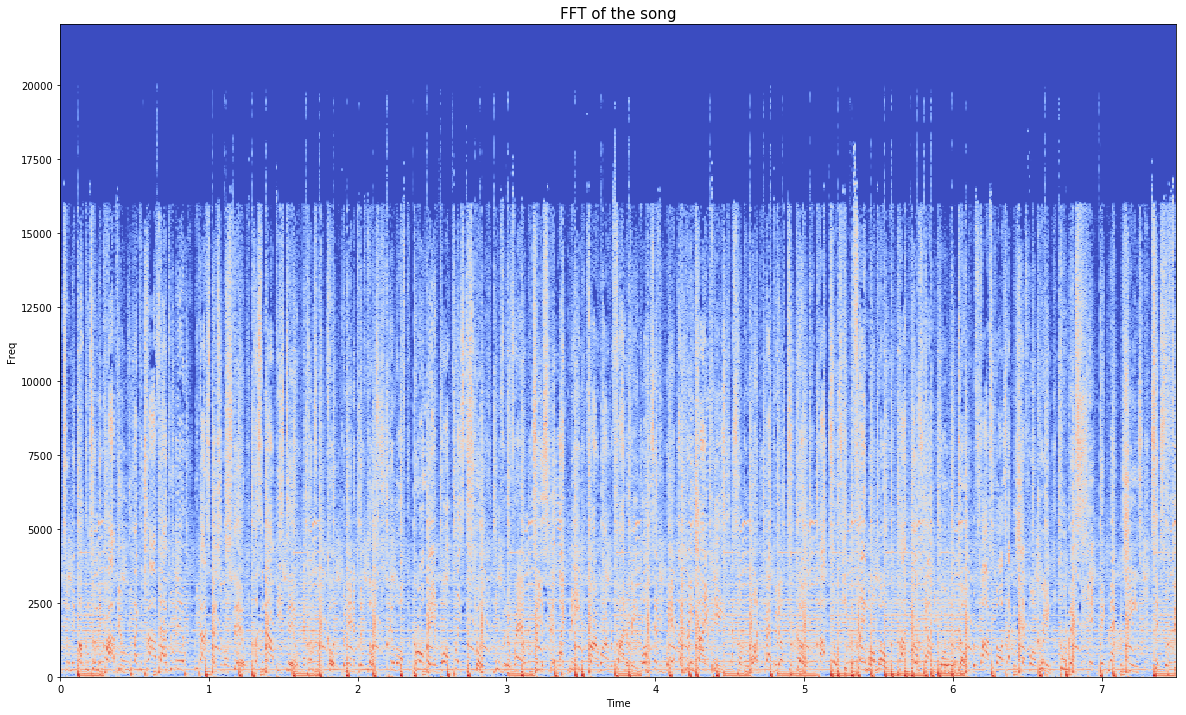

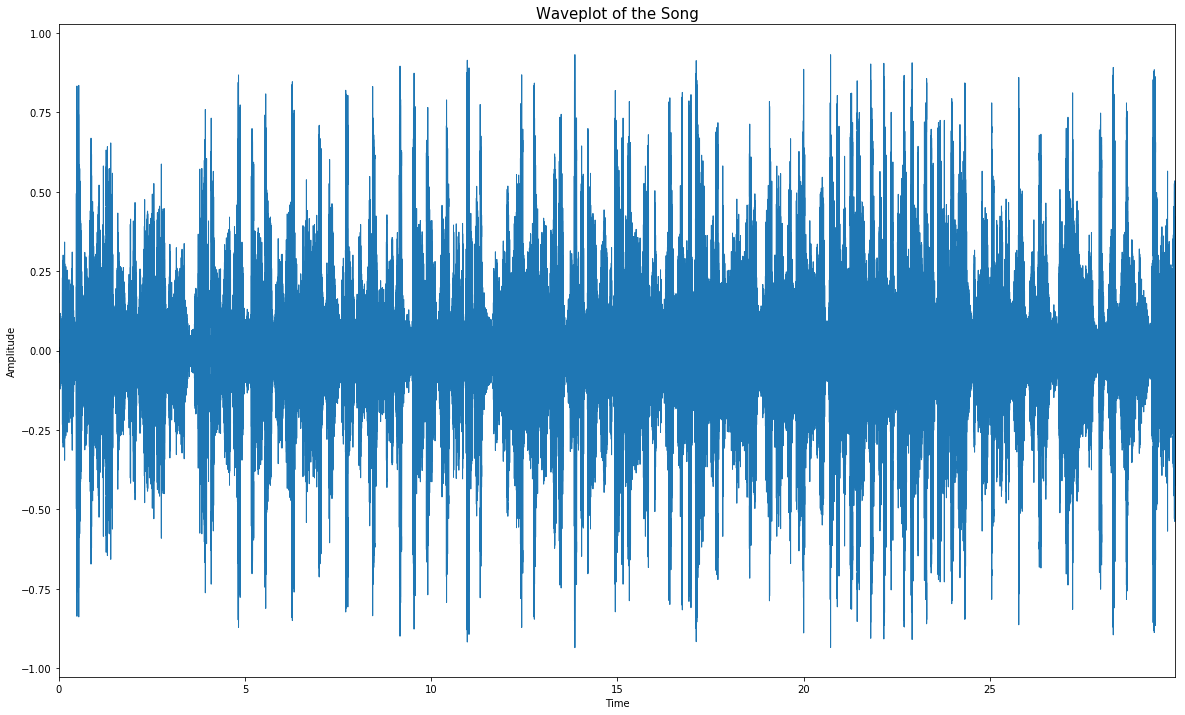

In [7]:
y, sr = librosa.load(base_song_path, sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100

D = librosa.stft(y, 
                 n_fft = 2048, 
                 hop_length = 2048, # hop_length = 20 ms
                 win_length = 2048,
                 window = signal.tukey(2048),
                ) 
Xdb = librosa.amplitude_to_db(abs(D))

print("Every sample will have a matrix of {}".format(Xdb.shape))

plt.figure(figsize=(20, 12))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Time")
plt.title("FFT of the song", fontsize=15)
plt.show()

plt.figure(figsize=(20, 12))
librosa.display.waveplot(y, sr=sr)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Waveplot of the Song", fontsize=15)
plt.show()

Now we can generate and save all matrices. Threading will decrease production time. Matrix were created before I wrote this notebook so code is commented to not do it every time. Those phase are quite time consuming (10 to 30 min).

In [ ]:
# def extract_spectrum(input_path):
#     y, sr = librosa.load(input_path, sr=None, mono = True)

#     if sr != 44100:
#         y = librosa.resample(y, sr, 44100)
#         sr = 44100

#     D = librosa.stft(y, 
#                      n_fft = 2048, 
#                      hop_length = 2048, # hop_length = 20 ms
#                      win_length = 2048,
#                      window = signal.tukey(2048),
#                     ) 
#     Xdb = librosa.amplitude_to_db(abs(D))
#     Xdb = Xdb.astype(np.float16)
#     Xdb = Xdb[:, :646]  # remove last columns depending on the exact duration of the song
    
#     return Xdb, y, sr

# def process_audio():
#     while True:
#         input_path = q.get()
#         if input_path is None:
#             break
        
#         filename = os.path.basename(input_path)[:-4]
#         output_path = os.path.join("preprocessed_audio", filename+".npy")

#         Xdb, y, sr = extract_spectrum(input_path)
        
#         np.save(output_path, Xdb)
#         q.task_done()
        
# q = queue.Queue()
# num_worker_threads = 25

# print("launch thread")
# threads = []
# for i in range(num_worker_threads):
#     t = threading.Thread(target=process_audio)
#     t.start()
#     threads.append(t)
    
# print("feeding queue")
# for audio_path in glob.glob(os.path.join("fma_small/*/*.mp3")):
#     filename = os.path.basename(audio_path)[:-4]
#     output_path = os.path.join("preprocessed_audio", filename+".npy")
#     if not os.path.exists(output_path):
#         q.put(audio_path)
# q.join()

# for i in range(num_worker_threads):
#     q.put(None)

# for t in threads:
#     t.join()
# print("end")

Now we have those datas prepared and stored. We can move to the processing using MFCC.

## Preparing MFCC datas

Based on <a href="https://www.youtube.com/watch?v=OpAdgx9wpXc">this study</a>, I wanted to try the same model as he did it on a very similar one with good result. The idea is to use MFCC to extract "bluckets" of frequencies. Then computer the Covariance Matrix is order to sum up the sample as a "correlation matrix" between frequencies. 

Every sample will have a matrix of (20, 2582)


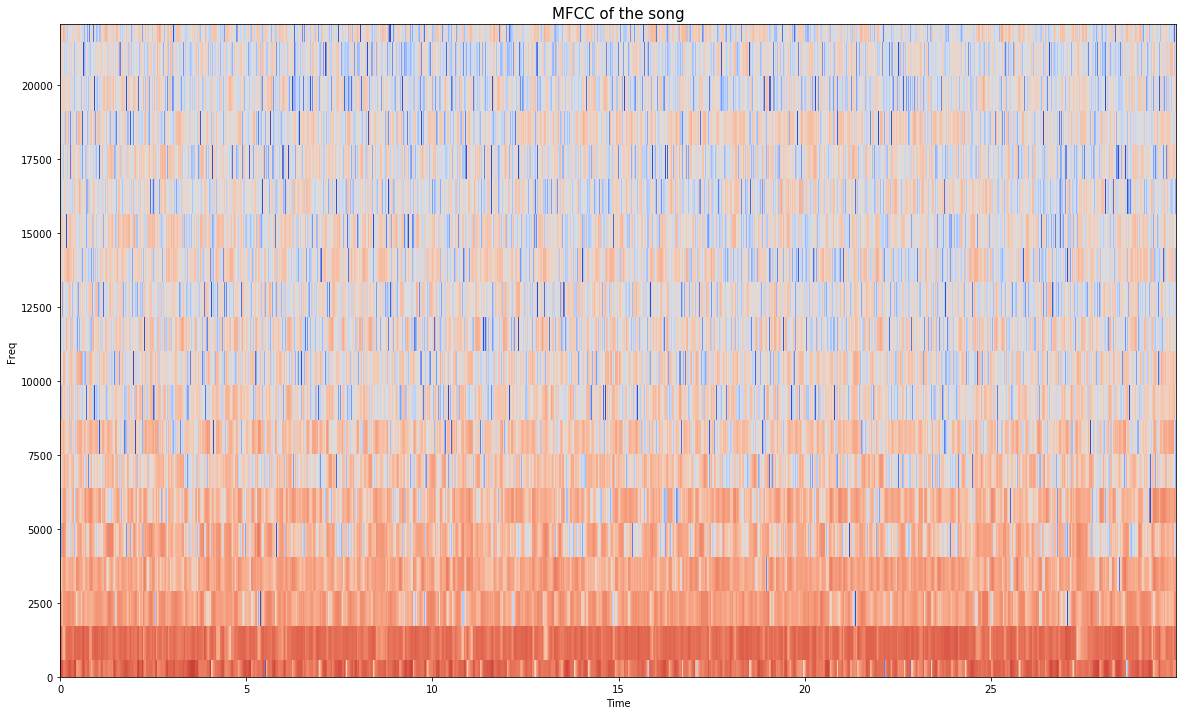

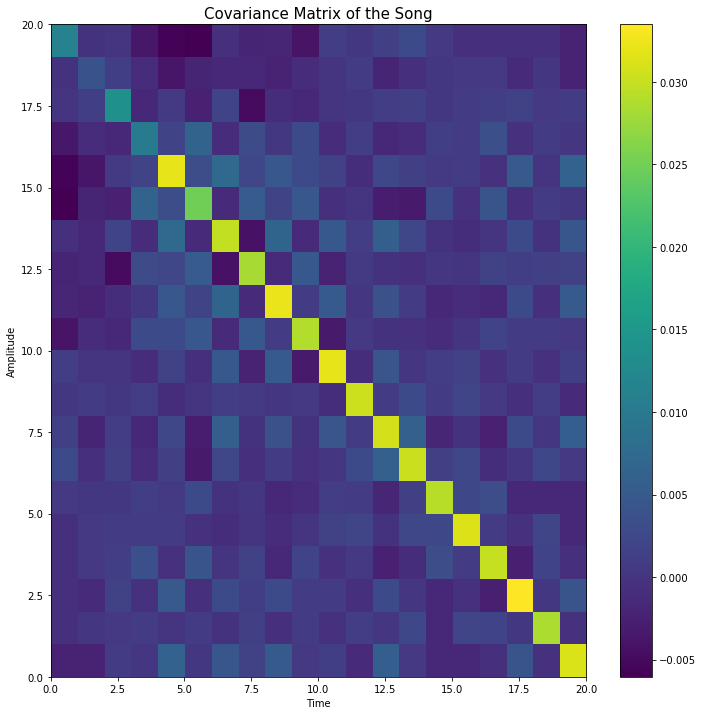

In [15]:
y, sr = librosa.load(base_song_path, sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100

mfcc = librosa.feature.mfcc(y=y, 
                           sr=sr,
                           n_mfcc = 20)
mfcc = librosa.amplitude_to_db(mfcc)

# normalization
mfcc_norm = mfcc - mfcc.min()
mfcc_norm /= mfcc.max()

Cov_norm = np.cov(mfcc_norm)

print("Every sample will have a matrix of {}".format(mfcc.shape))

plt.figure(figsize=(20, 12))
librosa.display.specshow(mfcc, sr=sr, x_axis='time', y_axis='hz')
plt.ylabel("Freq")
plt.xlabel("Time")
plt.title("MFCC of the song", fontsize=15)
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(Cov_norm, extent=[0, 20, 0, 20], aspect='auto');
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Covariance Matrix of the Song", fontsize=15)
plt.colorbar()
plt.show()

What we can see is that the Covariance Matrix is symmetric. What we can do is that case is to keep only one half as a vector. In that case, we will keep only :
* 20 datas for the diagonal
* (20 x 20 - 20)/2 for non diagonal values

Meaning that we can keep 210 values over 400 which is a reduction of 47.5% for free. Now to store those info we wil need ONLY 6.5 Mb. Which is very good. This will be done after the save of squared matrix as I thought about it just later

In [ ]:
# def extract_mfcc(input_path):
#     y, sr = librosa.load(input_path, sr=None, mono = True)

#     if sr != 44100:
#         y = librosa.resample(y, sr, 44100)
#         sr = 44100

#     mfcc = librosa.feature.mfcc(y=y, 
#                                sr=sr,
#                                n_mfcc = 20)
    
#     return librosa.power_to_db(mfcc)

# def process_audio_mfcc():
#     while True:
#         input_path = q.get()
#         if input_path is None:
#             break
        
#         filename = os.path.basename(input_path)[:-4]
#         output_path = os.path.join("preprocessed_audio", "MFCC", "non_norm", filename+".npy")
#         output_path_norm = os.path.join("preprocessed_audio", "MFCC", "norm", filename+".npy")
        
#         mfcc = extract_mfcc(input_path)
        
#         # normalization
#         mfcc_norm = mfcc - mfcc.min()
#         mfcc_norm /= mfcc.max()
        
#         # compute Covariance matrix
#         Cov = np.cov(mfcc)
#         Cov_norm = np.cov(mfcc_norm)
        
#         # I saved normalized and non normalized matrix but results are the same at the scale factor so you can keep only one
#         np.save(output_path, Cov)
#         np.save(output_path_norm, Cov_norm)
        
#         q.task_done()
        
# q = queue.Queue()
# num_worker_threads = 25

# print("launch thread")
# threads = []
# for i in range(num_worker_threads):
#     t = threading.Thread(target=process_audio_mfcc)
#     t.start()
#     threads.append(t)
    
# print("feeding queue")
# for audio_path in glob.glob(os.path.join("fma_small/*/*.mp3")):
#     filename = os.path.basename(audio_path)[:-4]
#     output_path = os.path.join("preprocessed_audio", "MFCC", filename+".npy")
#     if not os.path.exists(output_path):
#         q.put(audio_path)
# q.join()

# for i in range(num_worker_threads):
#     q.put(None)

# for t in threads:
#     t.join()
# print("end")

This model provide such a small dataset that we can directly store it in one matrix of 7994 x 210

In [8]:
X = []
for cov_path in glob.glob(os.path.join("preprocessed_audio/MFCC/norm/*.npy")):
    X_temp = np.load(cov_path)
    
    # keep only the 210 dimensions
    y_1 = np.diag(X_temp)
    y_2 = np.copy(X_temp)
    np.fill_diagonal(y_2, 0.)
    y_2 = squareform(y_2)
    
    # create a flat vector of this
    X.append(np.hstack((y_1, y_2)))
X = np.array(X)

# normalization of the Covariance matrix by observation
X -= X.min(axis=0)
X /= X.max(axis=0)

np.save("preprocessed_audio/mfcc_norm.npy", X)

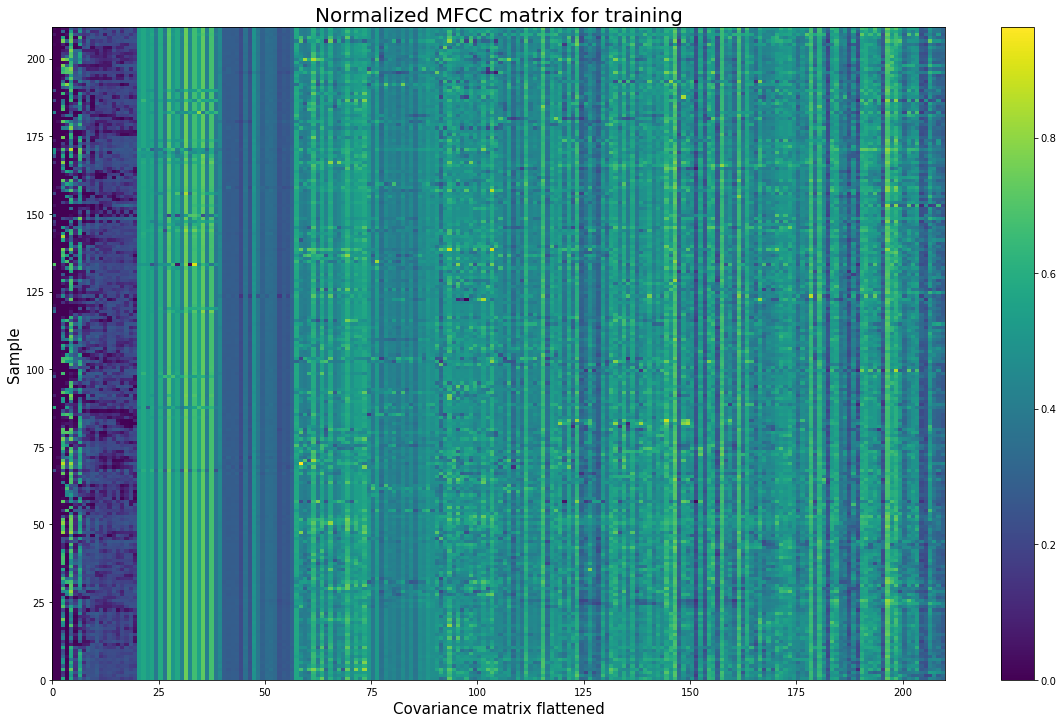

In [9]:
plt.figure(figsize = (20, 12))
plt.imshow(X[:210, :], extent=[0, 210, 0, 210], aspect='auto');
plt.title("Normalized MFCC matrix for training", fontsize=20)
plt.xlabel("Covariance matrix flattened", fontsize=15)
plt.ylabel("Sample", fontsize=15)
plt.colorbar()
plt.show()

The drawback of this method is that we compute an average of the complete sample. This is not optimal if the song change completely during the 30s. What we can do is compute this matrix for every 0.5s and use a RNN to do the classification.

## Preparing MFCC for RNN format

This preprocessing is very similar to what has been done previously so I'll directly apply it

In [ ]:
# def extract_mfcc(input_path):
#     y, sr = librosa.load(input_path, sr=None, mono = True)

#     if sr != 44100:
#         y = librosa.resample(y, sr, 44100)
#         sr = 44100

#     mfcc = librosa.feature.mfcc(y=y, 
#                                sr=sr,
#                                n_mfcc = 20)
    
#     return librosa.power_to_db(mfcc)

# def process_audio_mfcc_for_rnn():
#     while True:
#         input_path = q.get()
#         if input_path is None:
#             break
        
#         filename = os.path.basename(input_path)[:-4]
#         output_path = os.path.join("preprocessed_audio", "MFCC", "rnn", filename+".npy")

#         mfcc = extract_mfcc(input_path)
#         mfcc -= mfcc.min()
#         mfcc /= mfcc.max()
        
#         container = []
        
#         for i in range(60):  # we keep 43 frames to have 0.5 seconds slices - =60 frames
#             temp = mfcc[:, i*43:(i+1)*43]
#             Cov = np.cov(temp)
#             y_1 = np.diag(Cov)
#             y_2 = np.copy(Cov)
#             np.fill_diagonal(y_2, 0.)
#             y_2 = squareform(y_2)
#             container.append(np.hstack((y_1, y_2)))
            
#         container = np.array(container)
#         np.save(output_path, container)
        
#         q.task_done()
        
# q = queue.Queue()
# num_worker_threads = 25

# print("launch thread")
# threads = []
# for i in range(num_worker_threads):
#     t = threading.Thread(target=process_audio_mfcc_for_rnn)
#     t.start()
#     threads.append(t)
    
# print("feeding queue")
# for audio_path in glob.glob(os.path.join("fma_small/*/*.mp3")):
#     filename = os.path.basename(audio_path)[:-4]
#     output_path = os.path.join("preprocessed_audio", "MFCC", "rnn", filename+".npy")
#     if not os.path.exists(output_path):
#         q.put(audio_path)
# q.join()

# for i in range(num_worker_threads):
#     q.put(None)

# for t in threads:
#     t.join()
# print("end")

now we have matrices of 60 x 210. They are also quite light so we can directly store the complete matrix of 7994 x 60x 210 ready to be used with RNN so a phase of Scaling is required.

In [38]:
X = []
for cov_path in glob.glob(os.path.join("preprocessed_audio/MFCC/rnn/*.npy")):
    X_temp = np.load(cov_path)
    X_temp = MinMaxScaler().fit_transform(X_temp)
    X.append(X_temp)
X = np.array(X)
np.save("preprocessed_audio/mfcc_rnn.npy", X)

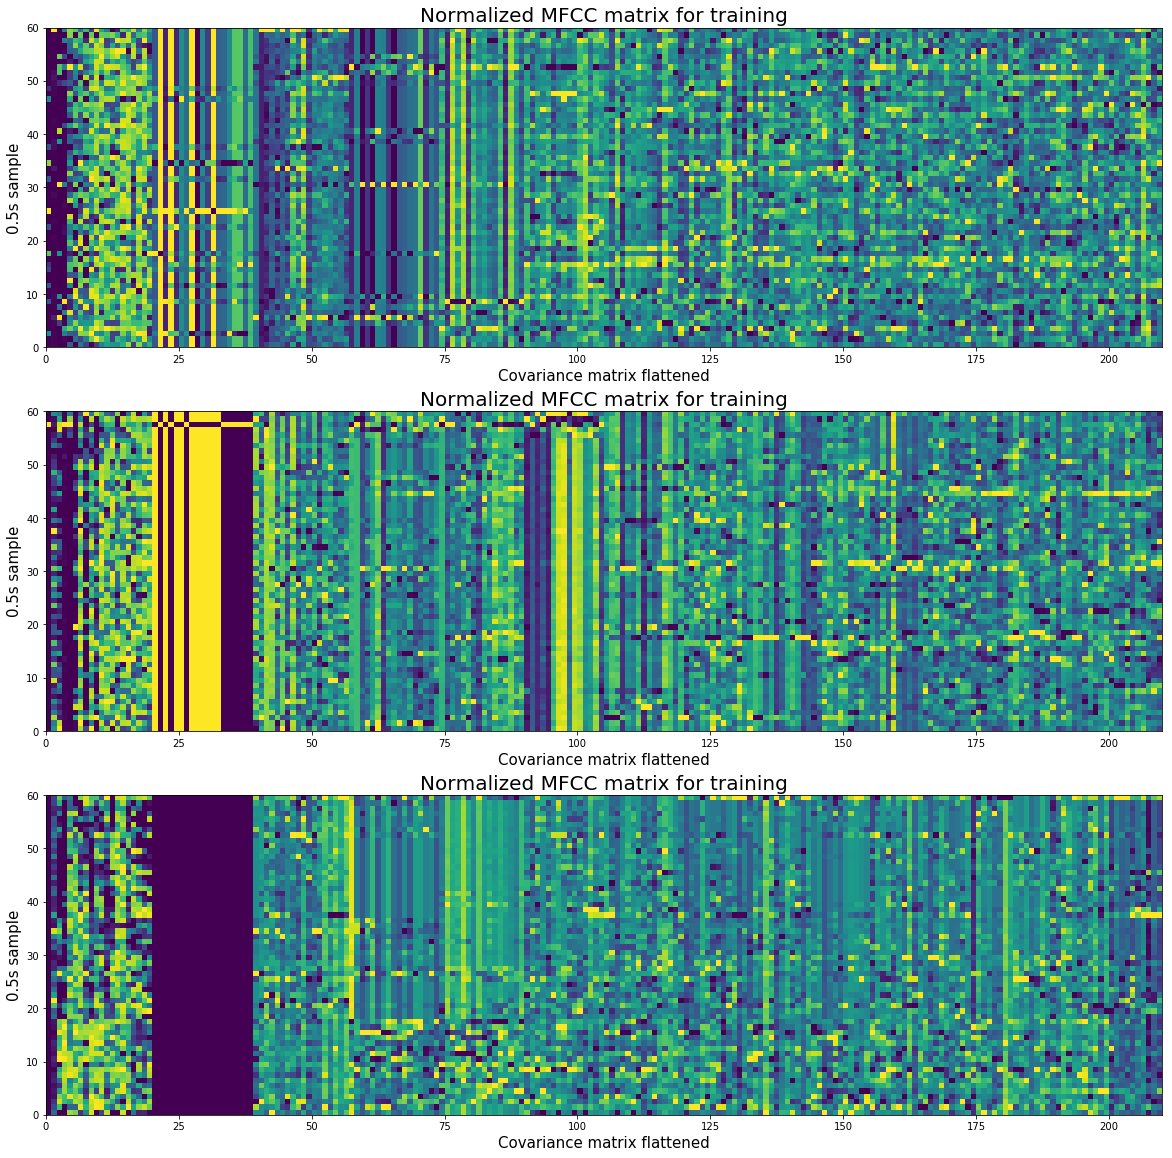

In [40]:
plt.figure(figsize = (20, 20))
plt.subplot(3, 1, 1)
plt.imshow(X[0, :, :], extent=[0, 210, 0, 60], aspect='auto');
plt.title("Normalized MFCC matrix of song 0", fontsize=20)
plt.xlabel("Covariance matrix flattened", fontsize=15)
plt.ylabel("0.5s sample", fontsize=15)

plt.subplot(3, 1, 2)
plt.imshow(X[42, :, :], extent=[0, 210, 0, 60], aspect='auto');
plt.title("Normalized MFCC matrix of song 42", fontsize=20)
plt.xlabel("Covariance matrix flattened", fontsize=15)
plt.ylabel("0.5s sample", fontsize=15)

plt.subplot(3, 1, 3)
plt.imshow(X[100, :, :], extent=[0, 210, 0, 60], aspect='auto');
plt.title("Normalized MFCC matrix of song 100", fontsize=20)
plt.xlabel("Covariance matrix flattened", fontsize=15)
plt.ylabel("0.5s sample", fontsize=15)
plt.show()

The benefit we have from the scaling by features is to absorb the fact that diagonal values are always more important due to correlation between them. This will help model to learn features.

# Models

First let's create our target matrix from the dataset we made previously

In [14]:
label = pd.read_csv("preprocessed_meta/classes.csv", index_col = 0)

enc = LabelBinarizer()
y_enc = enc.fit_transform(label.title.values.reshape(-1, 1))

I'll also put here all fixed functions required

In [15]:
def top1(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

def top2(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top4(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=4)

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_time_start = time.time()
        self.times = []
        self.losses = []
        self.val_losses = []
        self.top1 = []
        self.top2 = []
        self.top3 = []
        self.top4 = []
        self.val_top1 = []
        self.val_top2 = []
        self.val_top3 = []
        self.val_top4 = []
        
    def on_epoch_end(self, batch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_top1.append(logs.get('val_top1'))
        self.val_top2.append(logs.get('val_top2'))
        self.val_top3.append(logs.get('val_top3'))
        self.val_top4.append(logs.get('val_top4'))
    
    def on_batch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        self.losses.append(logs.get('loss'))
        self.top1.append(logs.get('top1'))
        self.top2.append(logs.get('top2'))
        self.top3.append(logs.get('top3'))
        self.top4.append(logs.get('top4'))
        
    def convert_to_dict(self):
        return {
            "time" : self.times,
            "loss" : self.losses,
            "val_loss" : self.val_losses,
            "top1" : self.top1,
            "val_top1" : self.val_top1,
            "top2" : self.top2,
            "val_top2" : self.val_top2,
            "top3" : self.top3,
            "val_top3" : self.val_top3,
            "top4" : self.top4,
            "val_top4" : self.val_top4,
        }

# CNN for FFT matrices

This model is the most complicated one as we cannot load the complete dataset in memory as it is close to 10gb. So we will have to create a generator and fit the model from it.

In [16]:
X = label.index.values
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

NB_IMAGES_TRAIN = X_train.shape[0]
NB_IMAGES_TEST = X_test.shape[0]
N, H, W, L = 7994, 1025, 646, 1
NB_CLASSES = 8
BATCH_SIZE = 10
EPOCHS  = 6

params_conv = {
    "kernel_size" : (2, 2), 
    "strides" : (1, 1),
    "activation" : 'relu',
    "padding" : 'same',
    "kernel_initializer" : "he_normal", 
    "bias_initializer" : "zeros", 
    "kernel_regularizer" : None
}

params_max_pool = {
    "pool_size" : (2, 2)
}

def batch_generator(idx_audio_list, classe, batch_size = 64):
    batch_features = np.zeros((batch_size, H, W, L))
    batch_labels = np.zeros((batch_size, 8))
    while True:
        for i in range(batch_size):
            index = np.random.choice(len(idx_audio_list), 1)
            idx_audio = idx_audio_list[index]
            file_path = os.path.join("preprocessed_audio", "spectrogram", "{0:06d}".format(idx_audio[0]) + ".npy")
            batch_features[i] = np.load(file_path).reshape(H, W, 1)
            batch_labels[i] = classe[index]
        batch_features = batch_features.astype(np.float32)
        batch_labels = batch_labels.astype(np.float32)
        batch_features -= batch_features.min()
        batch_features /= batch_features.max()
        yield batch_features, batch_labels
        
train_generator = batch_generator(X_train, y_train, BATCH_SIZE)
test_generator = batch_generator(X_test, y_test, BATCH_SIZE)

In [17]:
inputs = Input((H, W, L))

c1 = Conv2D(8, **params_conv) (inputs)
p1 = MaxPooling2D(pool_size = (2, 1)) (c1)

c2 = Conv2D(8, **params_conv) (p1)
p2 = MaxPooling2D(**params_max_pool) (c2)

c3 = Conv2D(16, **params_conv) (p2)
p3 = MaxPooling2D(**params_max_pool) (c3)

c4 = Conv2D(16, **params_conv) (p3)
p4 = MaxPooling2D(**params_max_pool) (c4)

c5 = Conv2D(32, **params_conv) (p4)
p5 = MaxPooling2D(**params_max_pool) (c5)

c6 = Conv2D(32, **params_conv) (p5)
p6 = MaxPooling2D(**params_max_pool) (c6)

c7 = Conv2D(64, **params_conv) (p6)
p7 = MaxPooling2D(**params_max_pool) (c7)

c8 = Conv2D(64, **params_conv) (p7)
p8 = MaxPooling2D(**params_max_pool) (c8)

f = Flatten() (p8)

d1 = Dense(100, activation='relu') (f)
d1 = Dropout(0.4) (d1)

d2 = Dense(30, activation='relu') (d1)
d2 = Dropout(0.2) (d2)

outputs = Dense(NB_CLASSES, activation='softmax') (d2)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1025, 646, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1025, 646, 8)      40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 646, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 646, 8)       264       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 323, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 323, 16)      528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 161, 16)      0         
__________

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics = ["binary_crossentropy", top1, top2, top3, top4])

In [19]:
time_callback = TimeHistory()

model.fit_generator(generator = train_generator,
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE,
                    verbose=1,
                    callbacks=[time_callback]
                    )

Epoch 1/6
639/639 [==============================] - 136s 212ms/step - loss: 0.3828 - binary_crossentropy: 0.3828 - top1: 0.1690 - top2: 0.3180 - top3: 0.4560 - top4: 0.5786 - val_loss: 0.3719 - val_binary_crossentropy: 0.3719 - val_top1: 0.1321 - val_top2: 0.2855 - val_top3: 0.4145 - val_top4: 0.5459
Epoch 2/6
639/639 [==============================] - 117s 184ms/step - loss: 0.3629 - binary_crossentropy: 0.3629 - top1: 0.2047 - top2: 0.3858 - top3: 0.5462 - top4: 0.6836 - val_loss: 0.3568 - val_binary_crossentropy: 0.3568 - val_top1: 0.2421 - val_top2: 0.4208 - val_top3: 0.5767 - val_top4: 0.6925
Epoch 3/6
639/639 [==============================] - 94s 147ms/step - loss: 0.3531 - binary_crossentropy: 0.3531 - top1: 0.2507 - top2: 0.4430 - top3: 0.5964 - top4: 0.7213 - val_loss: 0.3632 - val_binary_crossentropy: 0.3632 - val_top1: 0.2069 - val_top2: 0.3956 - val_top3: 0.5459 - val_top4: 0.6478
Epoch 4/6
639/639 [==============================] - 92s 144ms/step - loss: 0.3456 - binary_

In [20]:
with open('training_model_1.pkl', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# Fully Connected for MFCC

For this model, it's easier, a simple fully connected model will do the job. The complete dataset fit into memory and the training will be very fast.

In [4]:
X = np.load("preprocessed_audio/mfcc_norm.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

In [5]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               21100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 248       
Total params: 24,378
Trainable params: 24,378
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", top1, top2, top3, top4])

In [8]:
time_callback = TimeHistory()
model.fit(X_train, y_train, 
          epochs=150, 
          batch_size=100, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[time_callback])

Train on 6395 samples, validate on 1599 samples
Epoch 1/150
6395/6395 [==============================] - 3s 434us/step - loss: 0.3781 - binary_crossentropy: 0.3781 - top1: 0.1303 - top2: 0.2575 - top3: 0.3897 - top4: 0.5135 - val_loss: 0.3777 - val_binary_crossentropy: 0.3777 - val_top1: 0.1194 - val_top2: 0.2233 - val_top3: 0.3508 - val_top4: 0.4747
Epoch 2/150
6395/6395 [==============================] - 0s 53us/step - loss: 0.3766 - binary_crossentropy: 0.3766 - top1: 0.1376 - top2: 0.2697 - top3: 0.4023 - top4: 0.5196 - val_loss: 0.3767 - val_binary_crossentropy: 0.3767 - val_top1: 0.1176 - val_top2: 0.2339 - val_top3: 0.3558 - val_top4: 0.4659
Epoch 3/150
6395/6395 [==============================] - 0s 55us/step - loss: 0.3750 - binary_crossentropy: 0.3750 - top1: 0.1481 - top2: 0.2916 - top3: 0.4291 - top4: 0.5557 - val_loss: 0.3729 - val_binary_crossentropy: 0.3729 - val_top1: 0.2183 - val_top2: 0.4171 - val_top3: 0.5679 - val_top4: 0.6667
Epoch 4/150
6395/6395 [================

Epoch 28/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3509 - binary_crossentropy: 0.3509 - top1: 0.2643 - top2: 0.4385 - top3: 0.5819 - top4: 0.6980 - val_loss: 0.3418 - val_binary_crossentropy: 0.3418 - val_top1: 0.3158 - val_top2: 0.5266 - val_top3: 0.6460 - val_top4: 0.7548
Epoch 29/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.3507 - binary_crossentropy: 0.3507 - top1: 0.2663 - top2: 0.4432 - top3: 0.5775 - top4: 0.7012 - val_loss: 0.3461 - val_binary_crossentropy: 0.3461 - val_top1: 0.2989 - val_top2: 0.4984 - val_top3: 0.6360 - val_top4: 0.7505
Epoch 30/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3515 - binary_crossentropy: 0.3515 - top1: 0.2577 - top2: 0.4372 - top3: 0.5742 - top4: 0.6954 - val_loss: 0.3417 - val_binary_crossentropy: 0.3417 - val_top1: 0.3321 - val_top2: 0.5347 - val_top3: 0.6492 - val_top4: 0.7686
Epoch 31/150
6395/6395 [==============================] - 0s 53us/step - loss: 0.3515

Epoch 55/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3455 - binary_crossentropy: 0.3455 - top1: 0.2763 - top2: 0.4572 - top3: 0.5970 - top4: 0.7110 - val_loss: 0.3405 - val_binary_crossentropy: 0.3405 - val_top1: 0.3158 - val_top2: 0.5285 - val_top3: 0.6448 - val_top4: 0.7686
Epoch 56/150
6395/6395 [==============================] - 0s 55us/step - loss: 0.3462 - binary_crossentropy: 0.3462 - top1: 0.2760 - top2: 0.4610 - top3: 0.5948 - top4: 0.7101 - val_loss: 0.3415 - val_binary_crossentropy: 0.3415 - val_top1: 0.3240 - val_top2: 0.5316 - val_top3: 0.6492 - val_top4: 0.7636
Epoch 57/150
6395/6395 [==============================] - 0s 54us/step - loss: 0.3452 - binary_crossentropy: 0.3452 - top1: 0.2818 - top2: 0.4580 - top3: 0.5989 - top4: 0.7171 - val_loss: 0.3401 - val_binary_crossentropy: 0.3401 - val_top1: 0.3033 - val_top2: 0.5053 - val_top3: 0.6379 - val_top4: 0.7674
Epoch 58/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.3455

Epoch 82/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3434 - binary_crossentropy: 0.3434 - top1: 0.2846 - top2: 0.4658 - top3: 0.6038 - top4: 0.7203 - val_loss: 0.3378 - val_binary_crossentropy: 0.3378 - val_top1: 0.3346 - val_top2: 0.5328 - val_top3: 0.6592 - val_top4: 0.7711
Epoch 83/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3417 - binary_crossentropy: 0.3417 - top1: 0.2884 - top2: 0.4805 - top3: 0.6144 - top4: 0.7259 - val_loss: 0.3361 - val_binary_crossentropy: 0.3361 - val_top1: 0.3196 - val_top2: 0.5091 - val_top3: 0.6523 - val_top4: 0.7717
Epoch 84/150
6395/6395 [==============================] - 0s 52us/step - loss: 0.3427 - binary_crossentropy: 0.3427 - top1: 0.2902 - top2: 0.4704 - top3: 0.6034 - top4: 0.7124 - val_loss: 0.3397 - val_binary_crossentropy: 0.3397 - val_top1: 0.3233 - val_top2: 0.5022 - val_top3: 0.6460 - val_top4: 0.7661
Epoch 85/150
6395/6395 [==============================] - 0s 55us/step - loss: 0.3411

Epoch 109/150
6395/6395 [==============================] - 0s 57us/step - loss: 0.3410 - binary_crossentropy: 0.3410 - top1: 0.2918 - top2: 0.4730 - top3: 0.6092 - top4: 0.7220 - val_loss: 0.3383 - val_binary_crossentropy: 0.3383 - val_top1: 0.3215 - val_top2: 0.5066 - val_top3: 0.6460 - val_top4: 0.7686
Epoch 110/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.3411 - binary_crossentropy: 0.3411 - top1: 0.2927 - top2: 0.4715 - top3: 0.6017 - top4: 0.7198 - val_loss: 0.3383 - val_binary_crossentropy: 0.3383 - val_top1: 0.3265 - val_top2: 0.5197 - val_top3: 0.6529 - val_top4: 0.7705
Epoch 111/150
6395/6395 [==============================] - 0s 53us/step - loss: 0.3414 - binary_crossentropy: 0.3414 - top1: 0.2904 - top2: 0.4713 - top3: 0.6009 - top4: 0.7160 - val_loss: 0.3378 - val_binary_crossentropy: 0.3378 - val_top1: 0.3221 - val_top2: 0.5147 - val_top3: 0.6510 - val_top4: 0.7686
Epoch 112/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.

Epoch 136/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.3416 - binary_crossentropy: 0.3416 - top1: 0.2963 - top2: 0.4747 - top3: 0.6081 - top4: 0.7215 - val_loss: 0.3438 - val_binary_crossentropy: 0.3438 - val_top1: 0.2946 - val_top2: 0.4728 - val_top3: 0.5947 - val_top4: 0.7398
Epoch 137/150
6395/6395 [==============================] - 0s 51us/step - loss: 0.3406 - binary_crossentropy: 0.3406 - top1: 0.2941 - top2: 0.4760 - top3: 0.6069 - top4: 0.7179 - val_loss: 0.3393 - val_binary_crossentropy: 0.3393 - val_top1: 0.3208 - val_top2: 0.5053 - val_top3: 0.6391 - val_top4: 0.7624
Epoch 138/150
6395/6395 [==============================] - 0s 50us/step - loss: 0.3395 - binary_crossentropy: 0.3395 - top1: 0.2924 - top2: 0.4730 - top3: 0.6089 - top4: 0.7198 - val_loss: 0.3412 - val_binary_crossentropy: 0.3412 - val_top1: 0.3208 - val_top2: 0.5059 - val_top3: 0.6285 - val_top4: 0.7586
Epoch 139/150
6395/6395 [==============================] - 0s 53us/step - loss: 0.

In [9]:
with open('training_model_2.pkl', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# Recurrent Neural Network on MFCC

In [4]:
X = np.load("preprocessed_audio/mfcc_rnn.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

In [5]:
model = Sequential()
model.add(CuDNNLSTM(100, return_sequences=True, input_shape=(60, 210)))
model.add(CuDNNLSTM(75, return_sequences=True))
model.add(CuDNNLSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 60, 100)           124800    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 60, 75)            53100     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 50)                25400     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 208       
Total params: 204,783
Trainable params: 204,783
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", top1, top2, top3, top4])

In [7]:
time_callback = TimeHistory()

model.fit(X_train, y_train, 
          epochs=150, 
          batch_size=100, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[time_callback])

Train on 6395 samples, validate on 1599 samples
Epoch 1/150
6395/6395 [==============================] - 4s 662us/step - loss: 0.3697 - binary_crossentropy: 0.3697 - top1: 0.1769 - top2: 0.3471 - top3: 0.4833 - top4: 0.6206 - val_loss: 0.3654 - val_binary_crossentropy: 0.3654 - val_top1: 0.2258 - val_top2: 0.3909 - val_top3: 0.5278 - val_top4: 0.6792
Epoch 2/150
6395/6395 [==============================] - 2s 256us/step - loss: 0.3579 - binary_crossentropy: 0.3579 - top1: 0.2289 - top2: 0.4188 - top3: 0.5728 - top4: 0.6973 - val_loss: 0.3517 - val_binary_crossentropy: 0.3517 - val_top1: 0.2051 - val_top2: 0.4503 - val_top3: 0.5941 - val_top4: 0.7305
Epoch 3/150
6395/6395 [==============================] - 2s 256us/step - loss: 0.3508 - binary_crossentropy: 0.3508 - top1: 0.2580 - top2: 0.4580 - top3: 0.6109 - top4: 0.7307 - val_loss: 0.3465 - val_binary_crossentropy: 0.3465 - val_top1: 0.2977 - val_top2: 0.4728 - val_top3: 0.6010 - val_top4: 0.7455
Epoch 4/150
6395/6395 [==============

Epoch 28/150
6395/6395 [==============================] - 2s 274us/step - loss: 0.2635 - binary_crossentropy: 0.2635 - top1: 0.5110 - top2: 0.6862 - top3: 0.7962 - top4: 0.8721 - val_loss: 0.3381 - val_binary_crossentropy: 0.3381 - val_top1: 0.3721 - val_top2: 0.5697 - val_top3: 0.7117 - val_top4: 0.8099
Epoch 29/150
6395/6395 [==============================] - 2s 262us/step - loss: 0.2634 - binary_crossentropy: 0.2634 - top1: 0.5163 - top2: 0.6857 - top3: 0.7961 - top4: 0.8732 - val_loss: 0.3333 - val_binary_crossentropy: 0.3333 - val_top1: 0.3802 - val_top2: 0.5860 - val_top3: 0.7217 - val_top4: 0.8168
Epoch 30/150
6395/6395 [==============================] - 2s 263us/step - loss: 0.2553 - binary_crossentropy: 0.2553 - top1: 0.5293 - top2: 0.7048 - top3: 0.8066 - top4: 0.8824 - val_loss: 0.3324 - val_binary_crossentropy: 0.3324 - val_top1: 0.4059 - val_top2: 0.5897 - val_top3: 0.7217 - val_top4: 0.8186
Epoch 31/150
6395/6395 [==============================] - 2s 260us/step - loss: 0.

Epoch 55/150
6395/6395 [==============================] - 2s 254us/step - loss: 0.1730 - binary_crossentropy: 0.1730 - top1: 0.6998 - top2: 0.8194 - top3: 0.8871 - top4: 0.9334 - val_loss: 0.4728 - val_binary_crossentropy: 0.4728 - val_top1: 0.3996 - val_top2: 0.5566 - val_top3: 0.6692 - val_top4: 0.7749
Epoch 56/150
6395/6395 [==============================] - 2s 257us/step - loss: 0.1637 - binary_crossentropy: 0.1637 - top1: 0.7163 - top2: 0.8317 - top3: 0.8926 - top4: 0.9360 - val_loss: 0.4900 - val_binary_crossentropy: 0.4900 - val_top1: 0.3746 - val_top2: 0.5491 - val_top3: 0.6735 - val_top4: 0.7855
Epoch 57/150
6395/6395 [==============================] - 2s 258us/step - loss: 0.1622 - binary_crossentropy: 0.1622 - top1: 0.7181 - top2: 0.8281 - top3: 0.8946 - top4: 0.9400 - val_loss: 0.4921 - val_binary_crossentropy: 0.4921 - val_top1: 0.3752 - val_top2: 0.5547 - val_top3: 0.6817 - val_top4: 0.7892
Epoch 58/150
6395/6395 [==============================] - 2s 257us/step - loss: 0.

Epoch 108/150
6395/6395 [==============================] - 2s 261us/step - loss: 0.0333 - binary_crossentropy: 0.0333 - top1: 0.9517 - top2: 0.9815 - top3: 0.9906 - top4: 0.9952 - val_loss: 0.8985 - val_binary_crossentropy: 0.8985 - val_top1: 0.3508 - val_top2: 0.5059 - val_top3: 0.6373 - val_top4: 0.7492
Epoch 109/150
6395/6395 [==============================] - 2s 260us/step - loss: 0.0271 - binary_crossentropy: 0.0271 - top1: 0.9625 - top2: 0.9870 - top3: 0.9919 - top4: 0.9950 - val_loss: 0.9640 - val_binary_crossentropy: 0.9640 - val_top1: 0.3546 - val_top2: 0.5091 - val_top3: 0.6291 - val_top4: 0.7405
Epoch 110/150
6395/6395 [==============================] - 2s 257us/step - loss: 0.0608 - binary_crossentropy: 0.0608 - top1: 0.9110 - top2: 0.9659 - top3: 0.9847 - top4: 0.9923 - val_loss: 0.8538 - val_binary_crossentropy: 0.8538 - val_top1: 0.3602 - val_top2: 0.5016 - val_top3: 0.6460 - val_top4: 0.7542
Epoch 111/150
6395/6395 [==============================] - 2s 258us/step - loss

Epoch 135/150
6395/6395 [==============================] - 2s 257us/step - loss: 0.0344 - binary_crossentropy: 0.0344 - top1: 0.9556 - top2: 0.9826 - top3: 0.9936 - top4: 0.9980 - val_loss: 1.0224 - val_binary_crossentropy: 1.0224 - val_top1: 0.3596 - val_top2: 0.5084 - val_top3: 0.6273 - val_top4: 0.7442
Epoch 136/150
6395/6395 [==============================] - 2s 255us/step - loss: 0.0233 - binary_crossentropy: 0.0233 - top1: 0.9678 - top2: 0.9887 - top3: 0.9953 - top4: 0.9975 - val_loss: 1.0185 - val_binary_crossentropy: 1.0185 - val_top1: 0.3602 - val_top2: 0.5128 - val_top3: 0.6391 - val_top4: 0.7467
Epoch 137/150
6395/6395 [==============================] - 2s 257us/step - loss: 0.0217 - binary_crossentropy: 0.0217 - top1: 0.9737 - top2: 0.9934 - top3: 0.9978 - top4: 0.9987 - val_loss: 1.0415 - val_binary_crossentropy: 1.0415 - val_top1: 0.3609 - val_top2: 0.5134 - val_top3: 0.6341 - val_top4: 0.7486
Epoch 138/150
6395/6395 [==============================] - 2s 255us/step - loss

In [8]:
with open('training_model_3.pkl', 'wb') as file:
    pickle.dump(time_callback.convert_to_dict(), file)

# Analyse

Now we have our 3 models trained, we can use the callback saved to compare those models.

In [21]:
with open('training_model_1.pkl', 'rb') as file:
    mdl1 = pickle.load(file)
with open('training_model_2.pkl', 'rb') as file:
    mdl2 = pickle.load(file)
with open('training_model_3.pkl', 'rb') as file:
    mdl3 = pickle.load(file)
    
def lissage(Lx,Ly,p):
    '''Fonction qui débruite une courbe par une moyenne glissante
    sur 2P+1 points'''
    Lxout=[]
    Lyout=[]
    for i in range(p,len(Lx)-p):   
        Lxout.append(Lx[i])
    for i in range(p,len(Ly)-p):
        val=0
        for k in range(2*p):
            val+=Ly[i-p+k]
        Lyout.append(val/2/p)
            
    return Lxout,Lyout

First as you probably saw, the CNN has been trained only on 6 Epoch. This is because we have very quickly an important overfitting. We can see that if we look at the loss durint the trainting and test. There is a smoothing on the train set as I saved it at every batch. We can see that the loss continue du decrease for the train set when the loss on the test set explode. 

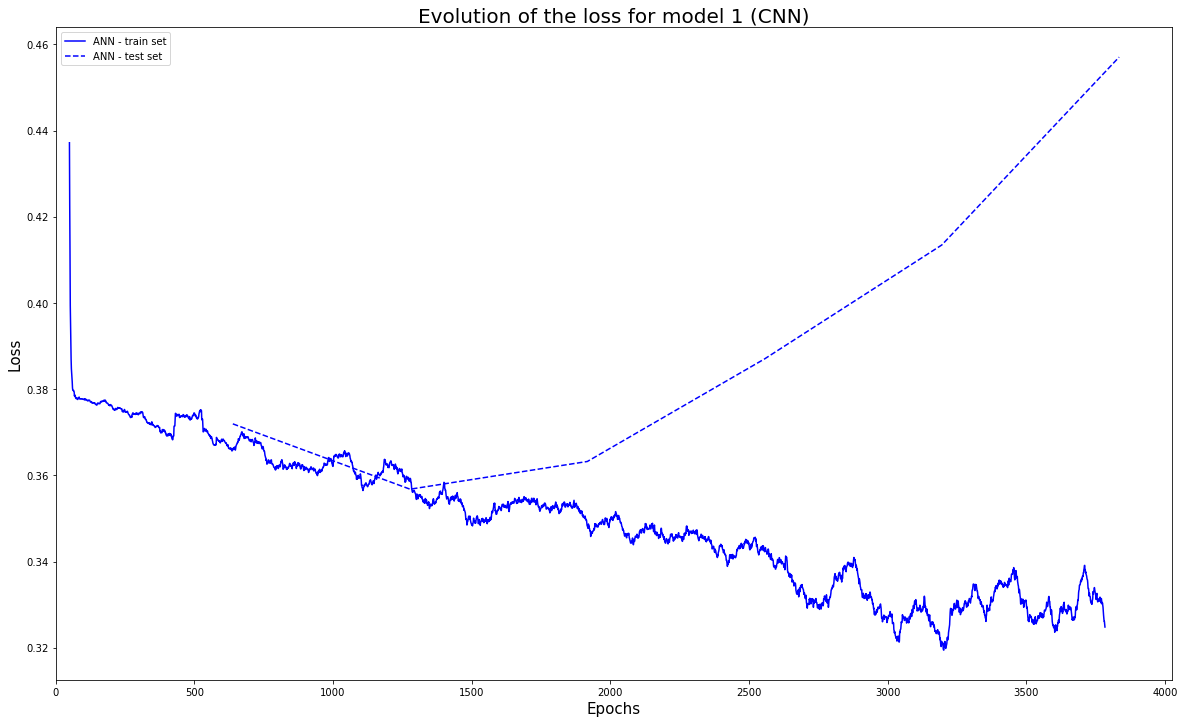

In [28]:
step = len(mdl1["loss"])//len(mdl1["val_loss"])
x1, y1 = list(range(len(mdl1["loss"]))), mdl1["loss"]
x2, y2 = [(i+1)*step for i in range(len(mdl1["val_loss"]))], mdl1["val_loss"]

x1, y1 = lissage(x1, y1, 50)

plt.figure(figsize=(20,12))
plt.plot(x1, y1, c="b", label="ANN - train set")
plt.plot(x2, y2, c="b", linestyle="--", label="ANN - test set")
plt.legend()
plt.title("Evolution of the loss for model 1 (CNN)", fontsize=20)
plt.xlabel("Batches", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xlim(0)
plt.show()

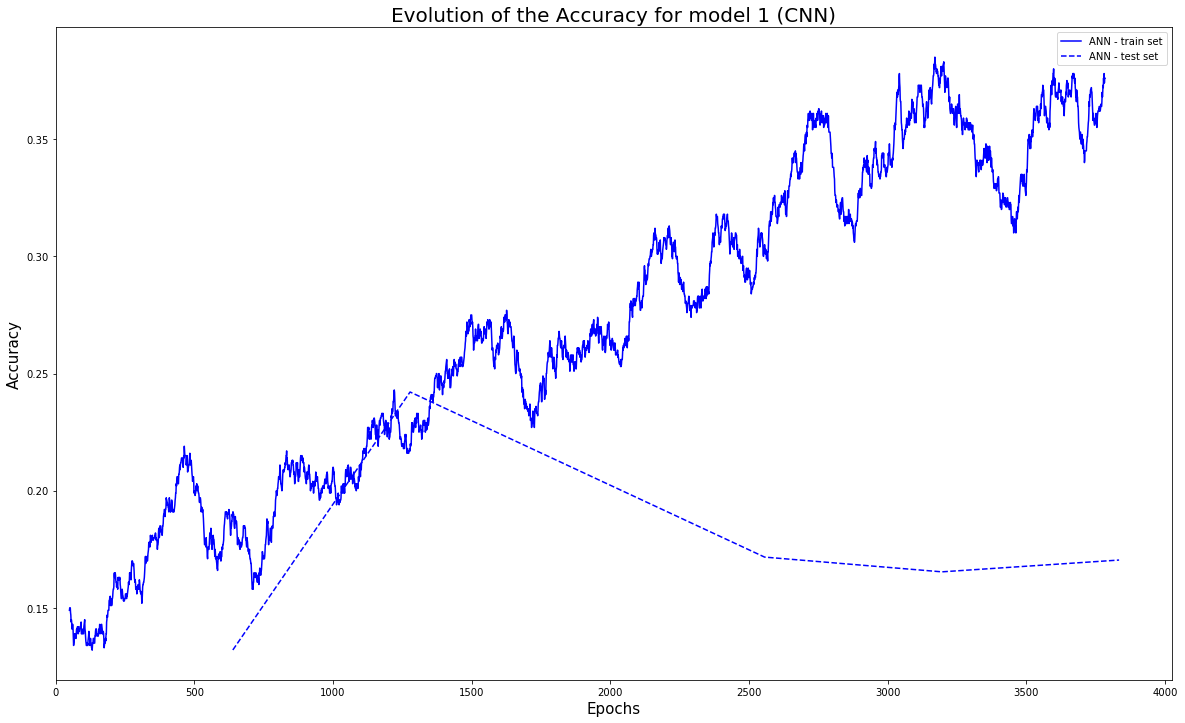

In [30]:
step = len(mdl1["top1"])//len(mdl1["val_top1"])
x1, y1 = list(range(len(mdl1["top1"]))), mdl1["top1"]
x2, y2 = [(i+1)*step for i in range(len(mdl1["val_top1"]))], mdl1["val_top1"]

x1, y1 = lissage(x1, y1, 50)

plt.figure(figsize=(20,12))
plt.plot(x1, y1, c="b", label="ANN - train set")
plt.plot(x2, y2, c="b", linestyle="--", label="ANN - test set")
plt.legend()
plt.title("Evolution of the Accuracy for model 1 (CNN)", fontsize=20)
plt.xlabel("Batches", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.xlim(0)
plt.show()

If we use an Early Stop and regularization, we may reach maybe 25 % of good prediction. This is only 2x more than a random agent who has 1/8 chance = 12.5%. Maybe with more data, we may be able to avoid overfitting but it's not a good model (slow to train, need lot of data = 10gB is this case) so we can now look at other models and see if they perform better.

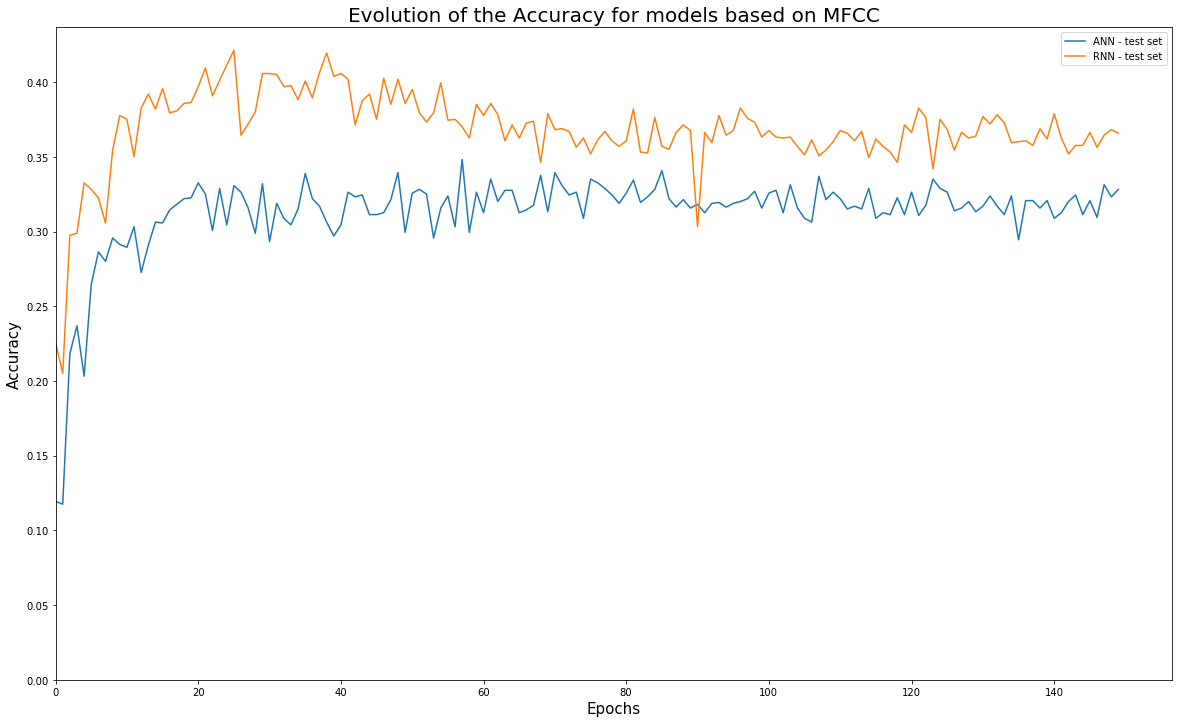

In [37]:
plt.figure(figsize=(20,12))
plt.plot(mdl2["val_top1"], label="ANN - test set")
plt.plot(mdl3["val_top1"], label="RNN - test set")
plt.title("Evolution of the Accuracy for models based on MFCC", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend()
plt.xlim(0)
plt.ylim(0)
plt.show()

We can definitely see that the RNN based on 60 x 0.5s of the sample is clearly better. We can look at the accuracy on train too or the loss to see if we have overfitting but currently this model is the best one.

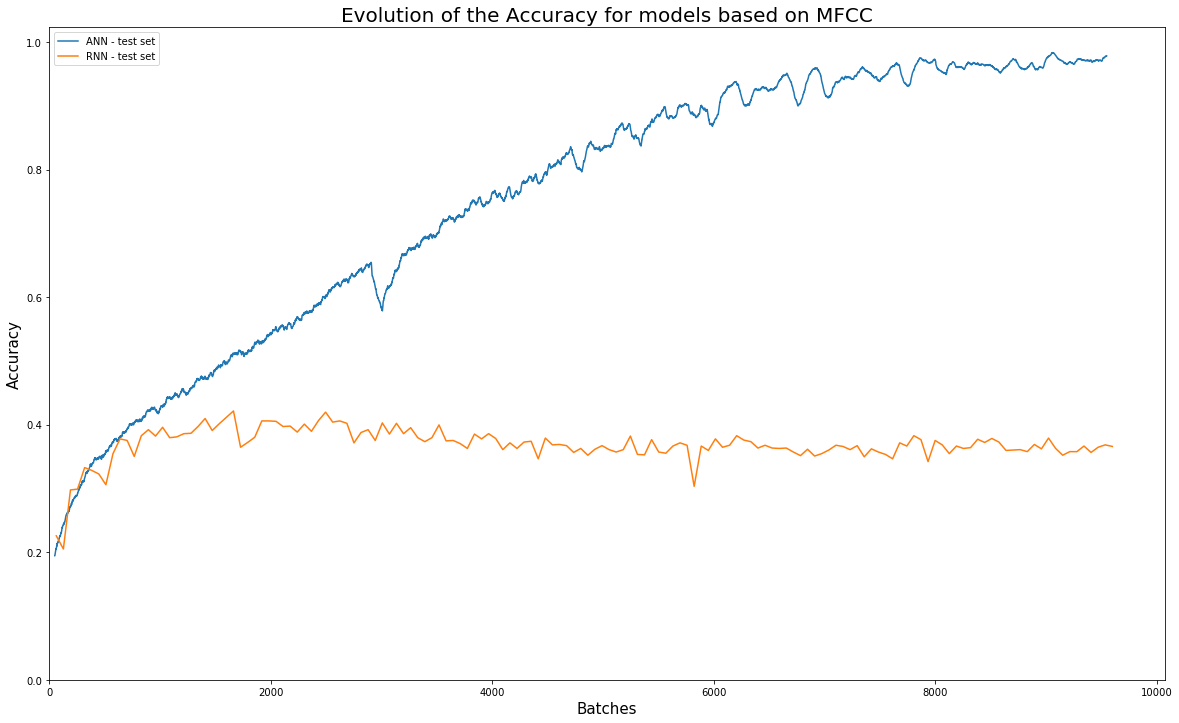

In [38]:
step = len(mdl3["top1"])//len(mdl3["val_top1"])
x1, y1 = list(range(len(mdl3["top1"]))), mdl3["top1"]
x2, y2 = [(i+1)*step for i in range(len(mdl3["val_top1"]))], mdl3["val_top1"]

x1, y1 = lissage(x1, y1, 50)

plt.figure(figsize=(20,12))
plt.plot(x1, y1, label="ANN - test set")
plt.plot(x2, y2, label="RNN - test set")
plt.title("Evolution of the Accuracy for models based on MFCC", fontsize=20)
plt.xlabel("Batches", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend()
plt.xlim(0)
plt.ylim(0)
plt.show()

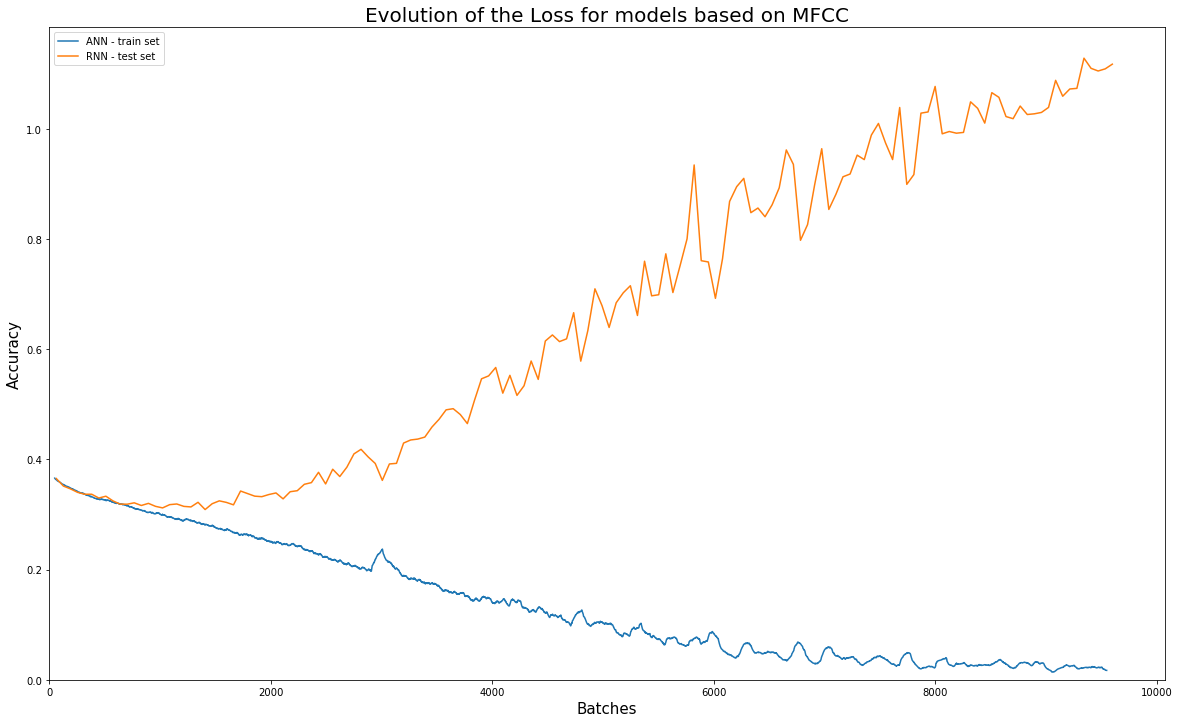

In [40]:
step = len(mdl3["loss"])//len(mdl3["val_loss"])
x1, y1 = list(range(len(mdl3["loss"]))), mdl3["loss"]
x2, y2 = [(i+1)*step for i in range(len(mdl3["val_loss"]))], mdl3["val_loss"]

x1, y1 = lissage(x1, y1, 50)

plt.figure(figsize=(20,12))
plt.plot(x1, y1, label="ANN - train set")
plt.plot(x2, y2, label="RNN - test set")
plt.title("Evolution of the Loss for models based on MFCC", fontsize=20)
plt.xlabel("Batches", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend()
plt.xlim(0)
plt.ylim(0)
plt.show()

In [41]:
max(mdl3["val_top1"])

0.4215134437789464

We have a huge overfitting. This is why we have kind of a bump at around 1500 batches. This bump is at around 42%. As a result, with a correct regularization and maybe a better adjustement of the topology, we could end up at maybe 45 % in top1. What we also have with this training is the accuracy on top 1 to 4. Let's look at this result. For example if we have 100% accuracy in top 2, it's still a very good model to support the user on classification.

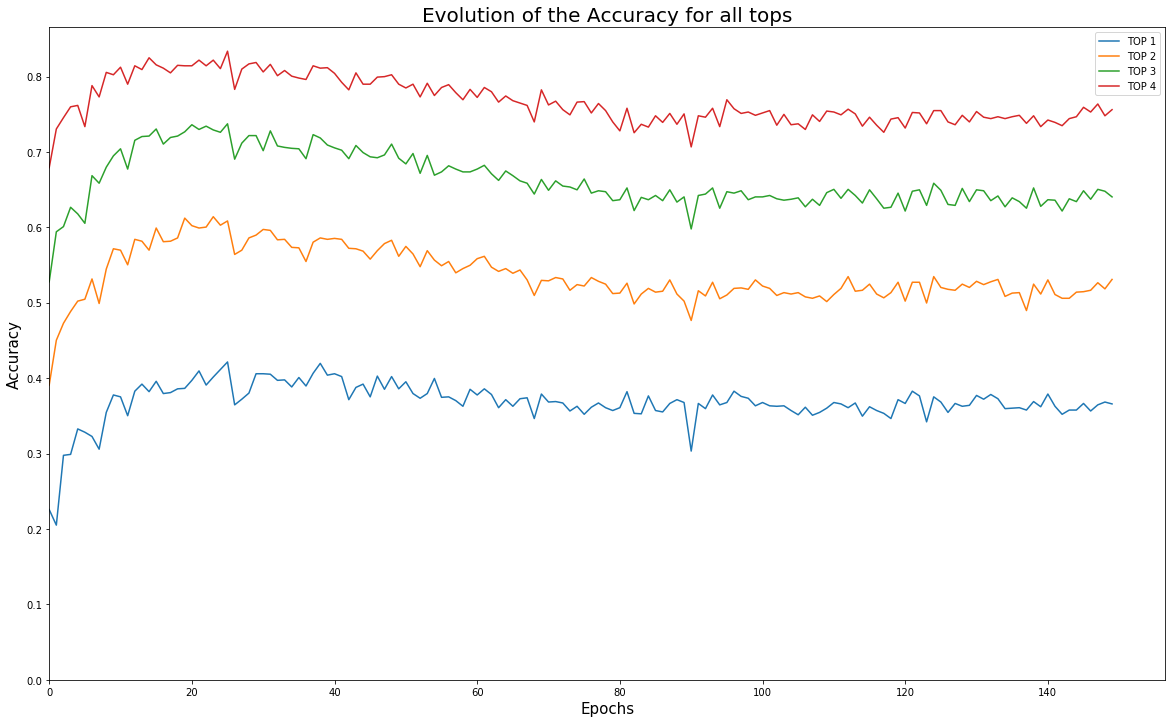

In [42]:
plt.figure(figsize=(20,12))
plt.plot(mdl3["val_top1"], label="TOP 1")
plt.plot(mdl3["val_top2"], label="TOP 2")
plt.plot(mdl3["val_top3"], label="TOP 3")
plt.plot(mdl3["val_top4"], label="TOP 4")
plt.title("Evolution of the Accuracy for all tops", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.legend()
plt.xlim(0)
plt.ylim(0)
plt.show()

On 3 of the 4 cases, we have the good prediction in the top3. We have only 8 classes so it's not perfect but we have now a good start to improve this model using additionnal datas.

# Conclusion

In conclusion, we discovered during this project that the solution used previously on audio mnist doesn't work. In this previous case, it worked bacause audio were very similar between train and test set. As it is only 3 person giving 50 times the same number. In this project we have a more realistic dataset with plenty of datas to experiment with. 

We used another way to pre-process the audio to improve classification a lot. In addition, this model is lighter and faster which is a very good point. 

The CNN overfittent very quickly the dataset as it tries to detect pattern but some pattern are present on multiple songs. The solution using MFCC on the full dataset decrease to much the data and creates a lack of information. The RNN solution using sub sample of the sample is quite good as we can highlight some temporal patterns. with datas still quite light. Of course we can adjust the filtering to have a bigger matrix (now we have 20 filters but maybe 30 would be better (this will end up with 465 features which is still ok for 8k observations). We will dig more in details in a future notebook about that.